$\qquad$ $\qquad$$\qquad$  **TDA 232 / DIT 381: Home Assignment 4, part 2 - Sequence learning  (10 points)** <br />
$\qquad$ $\qquad$$\qquad$ **Goal: Time series prediction using recurrent neural networks**<br />
$\qquad$ $\qquad$$\qquad$                   **Grader: Emilio, Simon** <br />
$\qquad$ $\qquad$$\qquad$                     **Due Date: 22/5** <br />
$\qquad$ $\qquad$$\qquad$                   **Submitted by: Name, Personal no., email** <br />

General guidelines:
* All solutions to theoretical and pratical problems must be submitted in this notebook, and equations should be formatted using LaTeX math-mode.
* For each exercise part, add cells containing the requested text, code or figures into this notebook.
* Your notebook should contain all required cell output, so that we don't have to execute the code. However, should we decide to, your notebook should run and reproduce the results up to stochastic variability. A good idea is to make sure it runs on Google Colab before submission.
* **Submit your solutions as notebook file (`.ipynb`) and in HTML format (`.html`).** To export this notebook to HTML format click `File` $\rightarrow$ `Download as` $\rightarrow$ `HTML`.

> **Note:** Training neural networks is computationally demanding and may take  time if you run it on your laptop. Running the code in Google Colab will likely be faster and you can even get access to a GPU.

> **Note:** To enable GPU hardware accelartion in Google Colab, click the `Change runtime type` field in the `runtime` drop-down menu, then choose `GPU` under hardware acceleration.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/simonpf/teaching/blob/master/machine_learning/2020/HW4b_2020.ipynb)

## Required software

In addition to `numpy` and `matplotlib`, you will need to install the following Python packages for  this assignment:
- `numpy`, `matplotlib`
- `pytorch`: Installation instructions can be found on the [pytorch homepage](https://pytorch.org/get-started/locally/) (pre-installed in Google Colab)
- `camels`: The data set we will be working with. To install it, run:

```
pip install camels

```

> **Note:** In Google Colab you can install packages using   `!pip  <package_name>`

# Assignment 5, Part 2

# Theoretical exercises

## [Exercise 1, 3 points]

Consider a RNN, which maps a sequence of inputs $x_0, x_1, \ldots$ to a sequence of outputs $y_0, y_1, \ldots$. At each step $t$, the hidden state $h_t$ and output $\hat{y}_t$ of the RNN are computed using
\begin{align}
  h_t &= \tanh( \mathbf{W}_{xh}\ x_t + \mathbf{W}_{hh} \ h_{t -1}) \\
  \hat{y}_t &= \mathbf{W}_{hy}\ h_t
\end{align}
  
### 1, a) (1 Point)

The RNN is applied to a sequence of two inputs $x_0, x_1$. Write down analytic expressions for the corresponding outputs $y_0, y_1$ assuming the initial hidden state to be the zero vector.

### 1, b) (1 Point)

Assume that the vectors $x_0, x_1$ have a length of 8, the hidden state $h_t$ a length of $16$ and the output vectors $\hat{y}_0, \hat{y}_1$ a length of 1. How many learnable parameters does the RNN described above have? How does this number depend on the length of the input sequence?

### 1, c) (1 Point)

Describe two diffculties that can occur when training RNNs.


# Practical exercises

In the practical part of the assignment you will use RNNs to predict the amount of water flowing in a stream or river, the so-called *streamflow*, from meteorological data.


## The data

The data that you will be using for the training comes from a scientific dataset named *Catchment Attributes and Meteorology for Large-sample Studies* (CAMELS). It is described in detail in the following paper:

A. Newman; K. Sampson; M. P. Clark; A. Bock; R. J. Viger; D. Blodgett, 2014. A large-sample watershed-scale hydrometeorological dataset for the contiguous USA. Boulder, CO: UCAR/NCAR. https://dx.doi.org/10.5065/D6MW2F4D

The dataset contains time series of streamflow combined with the most important *meteorological forcings* for the given river or stream. The forcing values describe the most important meteorological processes that determine the streamflow. The princpial forcing is of course precipitation, i.e. rain and snow, but also the temperature and strength of solar can indirectly influence the streamflow. These forcings have been aggregated over the drainage basin, which is the area upstream of the gauge measuring the streamflow in which precipitation will drain off into the river whose streamflow is being measured.

A model that predicts the strength of the flow in a river from meteorological inputs is called a run-off model.  Important applications of run-off models are predicting floods or analysing the impact of climate change on the stream and its surroundings.

In this exercise you will use the streamflow dataset to develop your own run-off model. For this you will use data from a single gauge, identified by the ID `13331500`. The plot below displays the location of the gauge:

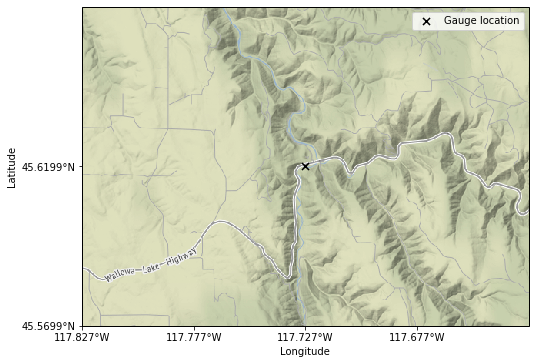

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import camels

gauge_id = 13331500
camels.plot_basin(gauge_id)

The `camels` package provides a Python interface for the streamflow data. Using the `camels.pytorch.Streamflow` class you can access the time series data directly as `pytorch` tensors.

The available data spans the time range from 1980 to 2014. Of that, the first 26 years are used as training data, years 2006 to 2010  as validation data and years 2010 to 2014 as testing data. 

In [2]:
from camels.pytorch import Streamflow
training_data = Streamflow(gauge_id, "training")
validation_data = Streamflow(gauge_id, "validation")

The plot below gives an overview over a period of three years from the training data. The first three panels show the six meteorological forcings that are the inputs for modeling the streamflow:
- length of the day
- strength of incoming solar radiation
- precipitation
- (water) vapor pressure, i.e. the amount of water vapor in the air
- daily minimum temperature
- daily maximum temperature

The lowest panel shows the measured streamflow.

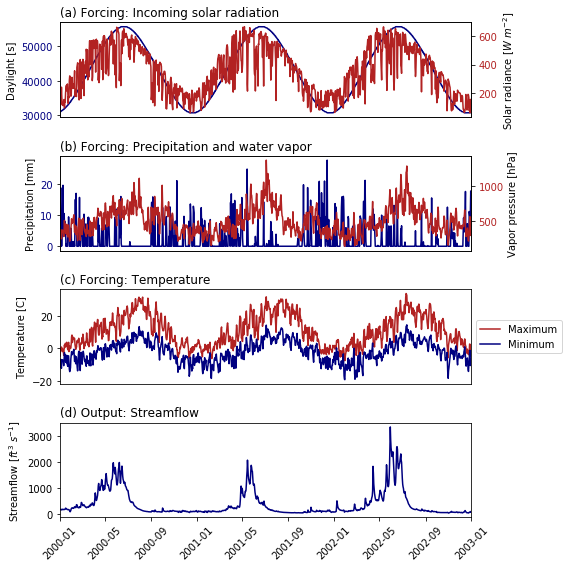

In [4]:
from datetime import datetime
start = datetime(2000, 1, 1, hour=0)
end = datetime(2003, 1, 1, hour=0)
training_data.plot_overview(start, end)

## [Exercise 1] (1 point) 

Describe any patterns you see in the time series of forcings and streamflow shown above. Provide a simple description of the physical processes that relate the forcings (input) to the streamflow (output).

### Training and testing data

The `Streamflow` dataset provides sequences of a length of 400 days of meteorological forcings and corresponding streamflows as samples. The `data_loader` member function can be used to instantiate `pytorch` dataloaders with a given batch size.

> **Note 1:** Input and outputs in the dataset are all normalized to have mean 0 and standard deviation 1. For simplicity, we will from now on consider forcings and outputs in normalized units instead of the units given in the plot above.

> **Note 2:** Pytorch expects tensors of sequences to have the elements in the sequence along the first dimension and the batch elements along the second. A tensor containing a batch of 8 samples from the `Streamflow` data thus
has shape `(200, 8, 6)`.

In [ ]:
training_loader = training_data.data_loader(batch_size=8)

## [Exercise 2] (2 points)

### 2, a) (1 point)

Write a custom `torch.nn.Module` subclass that implements the basic RNN from exercise 1 but including bias terms for the mappings from input to hidden state, hidden state to hidden state, and hidden state to output. This means
that for step $t$, the hidden state $h_t$ and output $\hat{y}_t$ should be given by:

\begin{align}
  h_t &= \tanh( \mathbf{W}_{hx}\ x_t + \theta_{hx} + \mathbf{W}_{hh} \ h_{t - 1} + \theta_{hh}) \\
  \hat{y}_t &= \mathbf{W}_{hy}\ h_t + \theta_y
\end{align}

Make the size of the hidden state a parameter of the class constructor.


> **Hint 1:** You can use `torch.nn.Linear` layers to implement the linear mappings between input, hidden state, and output.

### 2, b) (1 point)

Train an instance of your RNN model class using mean squared error (MSE) loss on the streamflow training data. For the hidden state, a size around $64$ is a suitable first choice.

Monitor the validation loss by computing the MSE for a single predicted sequence of streamflows for the full validation time range. You can obtain the input and output tensors corresponding to the full validation range by calling the `get_range` member function of `validation_data`:

```
x,y = validation_data.get_range()
```

Plot training and validation losses.

> **Hint 1:** To train your RNN you are free to use all available `pytorch` functionality. Particularly the [`torch.optim`](https://pytorch.org/docs/stable/optim.html) module can be of interest.

> **Hint 2:** As baseline, training using the `Adam` optimizer with a learning rate of $10^{-2}$ for 40 epochs should give a significant reduction in training loss. The reduction in the validation will likely be much smaller.


## [Exerise 3] (2 points)

### 3, a) (1 point)

Train a LSTM neural network on the streamflow data. The network should have at least one `LSTM` layer followed by fully-connected layer to map the hidden state to the output dimension.

> **Hint 1**: Use the `torch.nn.LSTM` class to implement the LSTM layer.

> **Hint 2:** Again, training using the `Adam` with a learning rate of $10^{-2}$ optimizer for 40 should give reasonable performance. 

### 3, b) (1 point)

Tune your model architecture and training routine to improve its performance. You should be able to achieve a validation loss of at least $0.45$. You could for example try a stacked LSTM or GRU cells.

### [Exerise 4] (2 points)

Evaluate all three models  on the test data. Make a plot with a panel for each of your models that shows predicted and true streamflow. Provide a table with mean absolute error, mean squared error and correlation coefficients. Describe main differences between the results for different models.

> **Hint:** For plotting, you can use `test_data.get_dates()` to get the dates corresponding to the sequence returned by `test_data.get_range()`.